Import section

In [148]:
import pandas as pd
import os
import numpy as np
import keras

from pandas import DataFrame
from math import sqrt
from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation

Constants

In [149]:
FILE_NAME = 'vegas.csv'

Loading dataset

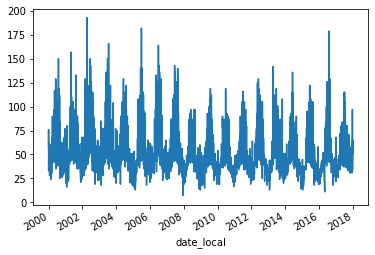

6007  entries


In [150]:
df = pd.read_csv(os.path.join(FILE_NAME), header=0, index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_values('date_local', ascending=True)
df['aqi'].plot()
pyplot.show()
total = len(df)
print(total, " entries")

Conversion to supervised learning

In [151]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [152]:
FORECAST_STEP = 7
PREVIOUS_STEP = 14
values = df.values
# number of features equels to number of columns - independent feature
n_features = len(df.columns)
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PREVIOUS_STEP, FORECAST_STEP)
# print(reframed.head())

In [153]:
# split into train and test sets
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split train into train and val sets
n_val_train = int(len(train) * 0.8)
val = train[n_val_train:, :]
train = train[:n_val_train, :]
# split into input and outputs

n_inputs = n_features * PREVIOUS_STEP
n_outputs = n_features * FORECAST_STEP

train_X, train_y = train[:, :n_inputs], train[:, np.array([i + n_inputs for i in range(n_features - 1, n_outputs, n_features)])]
val_X, val_y = val[:, :n_inputs], val[:, np.array([i + n_inputs for i in range(n_features - 1, n_outputs, n_features)])]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], PREVIOUS_STEP, n_features))

val_X = val_X.reshape((val_X.shape[0], PREVIOUS_STEP, n_features))

test_X, test_y = test[:, :n_inputs], test[:, np.array([i + n_inputs for i in range(n_features - 1, n_outputs, n_features)])]

print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(3831, 14, 4) (3831, 7) (958, 14, 4) (958, 7) (1198, 56) (1198, 7)


Epoch 1/200
60/60 [==============================] - 3s 25ms/step - loss: 0.0264 - val_loss: 0.0063
Epoch 2/200
60/60 [==============================] - 1s 22ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 3/200
60/60 [==============================] - 1s 22ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 4/200
60/60 [==============================] - 1s 22ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 5/200
60/60 [==============================] - 1s 22ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 6/200
60/60 [==============================] - 1s 22ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 7/200
60/60 [==============================] - 1s 22ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 8/200
60/60 [==============================] - 1s 21ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 9/200
60/60 [==============================] - 1s 21ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 10/200
60/60 [==============================] - 1s 24ms/step - loss: 0.0088 - val_loss: 0.0054

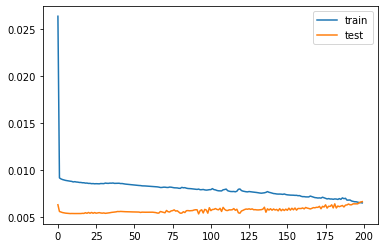

In [154]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
# design network
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(FORECAST_STEP))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam')

# model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(FORECAST_STEP))
# model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(val_X, val_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [155]:
def make_predictions(model, train, test, n_lag, n_seq, n_features):
    forecasts = list()

    for i in range(len(test)):
        X, y = test[i, :-(n_features * n_seq)], test[i, -(n_features * n_seq):]
        X = X.reshape((1, n_lag, n_features))
        forecast = model.predict(X, batch_size=16, verbose=0)
        forecasts.append([x for x in forecast[0, :]])
    return forecasts
        

In [156]:
def prep_data(scaler, test_X, test_y, forecasts, n_lag, n_seq, n_features, start):
    if len(test_X) - n_lag - n_seq < start:
        return
    past_data = []
    predicted = []
    groundtruth = []
    for i in range(0, n_lag * n_features, n_features):
        inv_y = np.concatenate(([test_X[start, i + n_features - 1]], test_X[start, i:i + n_features -1]))
        inv_y = scaler.inverse_transform(inv_y.reshape(1, n_features))
        past_data.append(inv_y[:,0])

    print(test_X.shape)
    for i in range(0, n_seq):
        inv_yhat = np.concatenate(([forecasts[start + n_lag][i]], test_X[start + n_lag + i, :n_features - 1]))
        inv_yhat = scaler.inverse_transform(inv_yhat.reshape(1, n_features))
        predicted.append(inv_yhat[:,0])

        ghd_y = np.concatenate(([test_y[start + n_lag][i]], test_X[start + n_lag + i, :n_features - 1]))
        ghd_y = scaler.inverse_transform(ghd_y.reshape(1, n_features))
        groundtruth.append(ghd_y[:,0])
        
    return past_data, predicted, groundtruth

In [157]:
def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = np.array(predictions) - np.array(actual)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('')
    print('')

In [158]:
def plot_multistep(history, prediction1, groundtruth , start , end):
    pyplot.figure(figsize=(20, 4))
    y_mean = np.mean(prediction1)
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    pyplot.plot(np.arange(range_history), np.array(history), label='History', marker='o')
    pyplot.plot(range_future, np.array(prediction1),label='Forecasted with LSTM', marker='o')
    pyplot.plot(range_future, np.array(groundtruth),label='GroundTruth', marker='o')
    pyplot.legend(loc='upper left')
    pyplot.title("Test Data from {} to {}, Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    pyplot.xlabel('Time step' ,  fontsize=18)
    pyplot.ylabel('y-value' , fontsize=18)

(1198, 56)
Test Data from 214 to 221
Mean Absolute Error: 0.06
Root Mean Square Error: 0.08




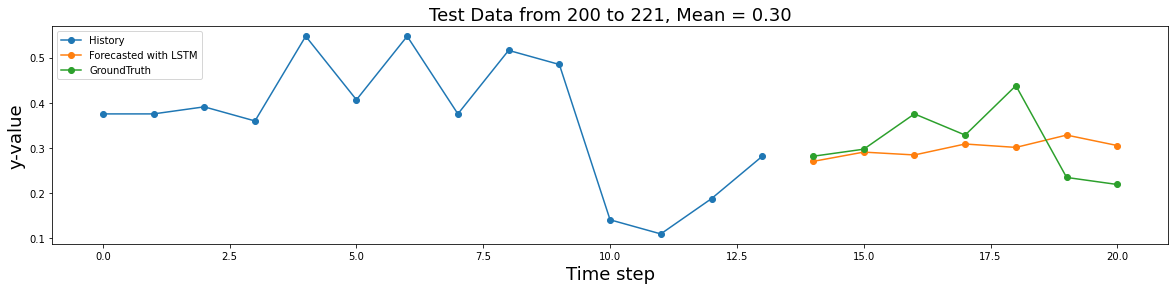

In [159]:
start = 200
forecasts = make_predictions(model, train, test, PREVIOUS_STEP, FORECAST_STEP, n_features)
past_data, predicted, groundtruth = prep_data(scaler, test_X, test_y, forecasts, PREVIOUS_STEP, FORECAST_STEP, n_features, start)
plot_multistep(past_data, predicted, groundtruth, start, start + PREVIOUS_STEP + FORECAST_STEP)
evaluate_prediction(predicted, groundtruth, 'LSTM', start + PREVIOUS_STEP, start + PREVIOUS_STEP + FORECAST_STEP)